In [ ]:
import urllib.request
urllib.request.urlretrieve("https://storage.yandexcloud.net/audioml-contest22/dataset.tar.gz", "dataset.tar.gz")

KeyboardInterrupt: ignored

In [ ]:
#!python naive_baseline.py --features-dir /content/train_features --tracks-meta /content/train_meta.tsv --output /content/out/text.txt

In [1]:
from google.colab import drive
drive.mount('drive')
#!cp /content/train_meta.tsv "drive/My Drive/"

Mounted at drive


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/train_features.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train_features')

In [3]:
import shutil
shutil.copy("/content/drive/MyDrive/train_meta.tsv", "/content/")

'/content/train_meta.tsv'

In [4]:
!cp /content/train_meta.tsv "drive/My Drive/"

In [ ]:
import tarfile
import zipfile
zipfile = '/content/dataset.tar.gz'
if zipfile.endswith("tar.gz"):
    tar = tarfile.open(zipfile, "r:gz")
elif zipfile.endswith("tar"):
    tar = tarfile.open(zipfile, "r:")
tar.extractall()
tar.close()  

In [5]:
!pip install annoy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 15.7 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=397045 sha256=39d35ee8e1996edfd68c2bd44abba1f23ee31a8fddab8f8ea3fedddf651097bc
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [6]:
# encoding=utf-8
import numpy as np
import pandas as pd
import os
from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from tqdm import tqdm
import random
import annoy

In [7]:


# Data Loader 

def train_val_split(dataset, val_size = 0.2): # Сплит по artistid
    artist_ids = dataset['artistid'].unique()
    train_artist_ids, val_artist_ids = train_test_split(artist_ids, test_size = val_size)
    trainset = dataset[dataset['artistid'].isin(train_artist_ids)].copy()
    valset = dataset[dataset['artistid'].isin(val_artist_ids)].copy()
    return trainset, valset

class FeaturesLoader: 
    def __init__(self, features_dir_path, meta_info, device='cpu', crop_size = 60):
        self.features_dir_path = features_dir_path
        self.meta_info = meta_info
        self.trackid2path = meta_info.set_index('trackid')['archive_features_path'].to_dict()
        self.crop_size = crop_size
        self.device = device
        
    def _load_item(self, track_id):
        track_features_file_path = self.trackid2path[track_id]
        track_features = np.load(os.path.join(self.features_dir_path, track_features_file_path))
        padding = (track_features.shape[1] - self.crop_size) // 2
        return track_features[:, padding:padding+self.crop_size]
    
    def load_batch(self, tracks_ids):
        batch = [self._load_item(track_id) for track_id in tracks_ids]
        return torch.tensor(np.array(batch)).to(self.device)

class TrainLoader:
    def __init__(self, features_loader, batch_size = 256, features_size = (512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        self.artist_track_ids = self.features_loader.meta_info.groupby('artistid').agg(list)
        
    def _generate_pairs(self, track_ids):
        np.random.shuffle(track_ids)
        pairs = [track_ids[i-2:i] for i in range(2, len(track_ids)+1, 2)]
        return pairs
        
    def _get_pair_ids(self):
        artist_track_ids = self.artist_track_ids.copy()
        artist_track_pairs = artist_track_ids['trackid'].map(self._generate_pairs)
        for pair_ids in artist_track_pairs.explode().dropna():
            yield pair_ids
            
    def _get_batch(self, batch_ids):
        batch_ids = np.array(batch_ids).reshape(-1)
        batch_features = self.features_loader.load_batch(batch_ids)
        batch_features = batch_features.reshape(self.batch_size, 2, *self.features_size)
        return batch_features
        
    def __iter__(self):
        batch_ids = []
        for pair_ids in self._get_pair_ids():
            batch_ids.append(pair_ids)
            if len(batch_ids) == self.batch_size:
                batch = self._get_batch(batch_ids)
                yield batch
                batch_ids = []

class TestLoader:
    def __init__(self, features_loader, batch_size = 256, features_size = (512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        
    def __iter__(self):
        batch_ids = []
        for track_id in tqdm(self.features_loader.meta_info['trackid'].values):
            batch_ids.append(track_id)
            if len(batch_ids) == self.batch_size:
                yield batch_ids, self.features_loader.load_batch(batch_ids) 
                batch_ids = []
        if len(batch_ids) > 0:
            yield batch_ids, self.features_loader.load_batch(batch_ids) 





In [ ]:
FeaturesLoader.load_batch

In [8]:
# Loss & Metrics

class NT_Xent(nn.Module):
    def __init__(self, temperature):
        super(NT_Xent, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
 
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        mask = self.mask_correlated_samples(batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        with torch.no_grad():
            top1_negative_samples, _ = negative_samples.topk(1)
            avg_rank = logits.argsort(descending=True).argmin(dim=1).float().mean().cpu().numpy()

        return loss, avg_rank

def get_ranked_list(embeds, top_size, annoy_num_trees = 32):
    annoy_index = None
    annoy2id = []
    id2annoy = dict()
    for track_id, track_embed in embeds.items():
        id2annoy[track_id] = len(annoy2id)
        annoy2id.append(track_id)
        if annoy_index is None:
            annoy_index = annoy.AnnoyIndex(len(track_embed), 'angular')
        annoy_index.add_item(id2annoy[track_id], track_embed)
    annoy_index.build(annoy_num_trees)
    ranked_list = dict()
    for track_id in embeds.keys():
        candidates = annoy_index.get_nns_by_item(id2annoy[track_id], top_size+1)[1:] # exclude trackid itself
        candidates = list(filter(lambda x: x != id2annoy[track_id], candidates))
        ranked_list[track_id] = [annoy2id[candidate] for candidate in candidates]
    return ranked_list

def position_discounter(position):
    return 1.0 / np.log2(position+1)   

def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg

def compute_dcg(query_trackid, ranked_list, track2artist_map, top_size):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list[:top_size]):
        assert result_trackid != query_trackid
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg

def eval_submission(submission, gt_meta_info, top_size = 100):
    track2artist_map = gt_meta_info.set_index('trackid')['artistid'].to_dict()
    artist2tracks_map = gt_meta_info.groupby('artistid').agg(list)['trackid'].to_dict()
    ndcg_list = []
    for query_trackid in tqdm(submission.keys()):
        ranked_list = submission[query_trackid]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count-1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist_map, top_size=top_size)
        try:
            ndcg_list.append(dcg/ideal_dcg)
        except ZeroDivisionError:
            continue
    return np.mean(ndcg_list)


In [106]:
def train(module, train_loader, val_loader, valset_meta, optimizer, criterion, num_epochs, checkpoint_path, top_size = 100):
    max_ndcg = None
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            module.train()
            x_i, x_j = batch[:, 0, :, :], batch[:, 1, :, :]
            h_i, h_j, z_i, z_j = module(x_i, x_j)
            loss, avg_rank = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("loss: {}".format(loss))
            print("avg_rank: {}".format(avg_rank))
            print()
        
        with torch.no_grad():
            model_encoder = module.encoder
            embeds_encoder = inference(model_encoder, val_loader)
            ranked_list_encoder = get_ranked_list(embeds_encoder, top_size)
            val_ndcg_encoder = eval_submission(ranked_list_encoder, valset_meta)
            
            model_projector = nn.Sequential(module.encoder, module.projector)
            embeds_projector = inference(model_projector, val_loader)
            ranked_list_projector = get_ranked_list(embeds_projector, top_size)
            val_ndcg_projector = eval_submission(ranked_list_projector, valset_meta)
            
            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)

def save_submission(submission, submission_path):
    with open(submission_path, 'w') as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result))))

In [180]:
# Train & Inference functions

class BasicNet(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.output_features_size = output_features_size
        self.kernel = 3
        self.conv_1 = nn.Conv1d(512, output_features_size, kernel_size=self.kernel, padding=1)
        self.conv_2 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)
        self.mp_1 = nn.MaxPool1d(2, 2)
        self.conv_3 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)
        self.conv_4 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)
        self.mp_2 = nn.MaxPool1d(2, 2)
        self.conv_5 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)
        self.conv_6 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)

        #self.mp_3 = nn.MaxPool1d(2, 2)
        #self.conv_6 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)
        #self.conv_7 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = self.conv_4(x).mean(axis = 2)
        return x

class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim):
        super().__init__()
        self.encoder = encoder
        self.n_features = encoder.output_features_size 
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            #nn.Linear(self.n_features, self.n_features, bias=False),
            #nn.ReLU(),
            nn.Linear(self.n_features, self.projection_dim, bias=False),
        )
        
    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)#.view(-1, 64*15)
        h_j = self.encoder(x_j)#.view(-1, 64*15)
        #print(x_i.shape)

        #print(h_i.shape)
        #print(h_j.shape)
        
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        #z_i = self.projector(h_i.view(-1, 64*15))
        #z_j = self.projector(h_j.view(-1, 64*15))
        return h_i, h_j, z_i, z_j
#(32768x15 and 64x64)
def inference(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features)#.view(-1, 64*15)
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds
def inference1(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model[1](model[0](tracks_features).view(-1, 64*15))
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds

In [181]:

#parser = ArgumentParser(description='Simple naive baseline')
#parser.add_argument('--base-dir', dest='base_dir', action='store', required=True)
#args = parser.parse_args()

base_dir = '/content'
    # Seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

TRAINSET_DIRNAME = 'train_features'
TESTSET_DIRNAME = 'test_features'
TRAINSET_META_FILENAME = 'train_meta.tsv'
TESTSET_META_FILENAME = 'test_meta.tsv'
SUBMISSION_FILENAME = 'submission.txt'
MODEL_FILENAME = 'model.pt'
CHECKPOINT_FILENAME = 'best.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 512
N_CHANNELS = 128
PROJECTION_DIM = 256
NUM_EPOCHS = 20
LR = 1e-4
TEMPERATURE = 0.1

TRAINSET_PATH = os.path.join(base_dir, TRAINSET_DIRNAME)
TESTSET_PATH = os.path.join(base_dir, TESTSET_DIRNAME)
TRAINSET_META_PATH = os.path.join(base_dir, TRAINSET_META_FILENAME)
TESTSET_META_PATH = os.path.join(base_dir, TESTSET_META_FILENAME)
SUBMISSION_PATH = os.path.join(base_dir, SUBMISSION_FILENAME)
MODEL_PATH = os.path.join(base_dir, MODEL_FILENAME)
CHECKPOINT_PATH = os.path.join(base_dir, CHECKPOINT_FILENAME)


In [ ]:

sim_clr = SimCLR(
    encoder = BasicNet(N_CHANNELS),
    projection_dim = PROJECTION_DIM
).to(device)
'''
sim_clr = SimCLR(
    encoder = autoen.encoder,
    projection_dim = PROJECTION_DIM
).to(device)'''
train_meta_info = pd.read_csv(TRAINSET_META_PATH, sep='\t')
#test_meta_info = pd.read_csv(TESTSET_META_PATH, sep='\t')
train_meta_info, validation_meta_info = train_val_split(train_meta_info, val_size=0.2)

print("Loaded data")
print("Train set size: {}".format(len(train_meta_info)))
print("Validation set size: {}".format(len(validation_meta_info)))
#print("Test set size: {}".format(len(test_meta_info)))
print()

print("Train")
train(
        module = sim_clr,
        train_loader = TrainLoader(FeaturesLoader(TRAINSET_PATH, train_meta_info, device), batch_size = BATCH_SIZE),
        val_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),
        valset_meta = validation_meta_info,
        optimizer = torch.optim.Adam(sim_clr.parameters(), lr = LR),
        criterion = NT_Xent(temperature = TEMPERATURE),
        num_epochs = NUM_EPOCHS,
        checkpoint_path = CHECKPOINT_PATH
)

print("Submission")
#test_loader = TestLoader(FeaturesLoader(TESTSET_PATH, test_meta_info, device), batch_size = BATCH_SIZE)
#model = sim_clr.encoder
#embeds = inference(model, test_loader)
#submission = get_ranked_list(embeds, 100)
#save_submission(submission, SUBMISSION_PATH)
#torch.save(sim_clr.state_dict(), MODEL_PATH)

Loaded data
Train set size: 39917
Validation set size: 9949

Train


0it [00:00, ?it/s]

Epoch 1/20


1it [00:03,  3.10s/it]

loss: 6.848399639129639
avg_rank: 222.251953125

Epoch 1/20


2it [00:05,  2.69s/it]

loss: 6.755856990814209
avg_rank: 199.232421875

Epoch 1/20


3it [00:07,  2.25s/it]

loss: 6.661728382110596
avg_rank: 199.5078125

Epoch 1/20


4it [00:08,  1.95s/it]

loss: 6.5314717292785645
avg_rank: 194.091796875

Epoch 1/20


5it [00:09,  1.65s/it]

loss: 6.33939790725708
avg_rank: 185.283203125

Epoch 1/20


6it [00:10,  1.38s/it]

loss: 6.248264789581299
avg_rank: 182.705078125

Epoch 1/20


7it [00:11,  1.20s/it]

loss: 6.12133264541626
avg_rank: 170.5234375

Epoch 1/20


8it [00:12,  1.09s/it]

loss: 6.014343738555908
avg_rank: 160.4921875

Epoch 1/20


9it [00:13,  1.02s/it]

loss: 6.090710163116455
avg_rank: 182.28515625

Epoch 1/20


10it [00:14,  1.04it/s]

loss: 6.010486125946045
avg_rank: 172.37890625

Epoch 1/20


11it [00:14,  1.07it/s]

loss: 5.8868727684021
avg_rank: 154.6494140625

Epoch 1/20


12it [00:17,  1.55s/it]

loss: 5.852413177490234
avg_rank: 147.9619140625

Epoch 1/20


13it [00:20,  1.97s/it]

loss: 5.888524055480957
avg_rank: 160.4443359375

Epoch 1/20


14it [00:23,  2.26s/it]

loss: 5.813045978546143
avg_rank: 149.685546875

Epoch 1/20


15it [00:26,  2.44s/it]

loss: 5.810052871704102
avg_rank: 153.515625

Epoch 1/20


16it [00:29,  2.59s/it]

loss: 5.666943073272705
avg_rank: 128.419921875

Epoch 1/20


17it [00:32,  2.67s/it]

loss: 5.758700370788574
avg_rank: 142.3994140625

Epoch 1/20


18it [00:35,  2.75s/it]

loss: 5.685309410095215
avg_rank: 126.29296875

Epoch 1/20


19it [00:38,  2.79s/it]

loss: 5.455661773681641
avg_rank: 114.1005859375

Epoch 1/20


20it [00:41,  2.80s/it]

loss: 5.659786701202393
avg_rank: 136.234375

Epoch 1/20


21it [00:43,  2.82s/it]

loss: 5.518552303314209
avg_rank: 121.0634765625

Epoch 1/20


22it [00:46,  2.84s/it]

loss: 5.500095367431641
avg_rank: 120.0947265625

Epoch 1/20


23it [00:49,  2.83s/it]

loss: 5.568464756011963
avg_rank: 118.5537109375

Epoch 1/20


24it [00:52,  2.88s/it]

loss: 5.476482391357422
avg_rank: 116.7353515625

Epoch 1/20


25it [00:55,  2.93s/it]

loss: 5.445505142211914
avg_rank: 110.0556640625

Epoch 1/20


26it [00:58,  2.96s/it]

loss: 5.5308098793029785
avg_rank: 119.8427734375

Epoch 1/20


27it [01:01,  2.95s/it]

loss: 5.339969158172607
avg_rank: 99.716796875

Epoch 1/20


28it [01:04,  2.94s/it]

loss: 5.365002632141113
avg_rank: 110.9873046875



**Encoder**

In [11]:
def train_ae(module, train_loader,optimizer, criterion, num_epochs): #, val_loader, valset_meta, optimizer, criterion, num_epochs, checkpoint_path, top_size = 100):
    max_ndcg = None
    losses = []
    for epoch in range(num_epochs):
        for tracks_ids, tracks_features in train_loader:
            optimizer.zero_grad()
            module.train()
            reconstructed, _ = module(tracks_features)
            loss = criterion(reconstructed, tracks_features)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("loss: {}".format(loss))
            print()
            losses.append(loss.item())
        '''with torch.no_grad():
            module.eval()
            for X_batch in val_loader:
                X_batch = X_batch.view(-1, 3, 64, 64).float()
                reconstructed, _ = model(X_batch.to(device))
                loss = loss_fn(reconstructed.view(-1, 3, 64, 64), X_batch.to(device))
                val_losses_per_epoch.append(loss.item())
            
            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)'''
    return losses

In [90]:

class Autoencoder(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.n_features = output_features_size

        self.encoder = nn.Sequential(
            nn.Conv1d(512, self.n_features, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features, self.n_features, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features, self.n_features//2, kernel_size=3, padding=1),

            nn.MaxPool1d(2, 2, return_indices=False),

            nn.Conv1d(self.n_features//2, self.n_features//2, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//2, self.n_features//4, kernel_size=3, padding=1),

            nn.Conv1d(self.n_features//4, self.n_features//4, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//4, self.n_features//8, kernel_size=3, padding=1),

            nn.MaxPool1d(2, 2, return_indices=False),

            nn.Conv1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1)
        )
       
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1),
            nn.ConvTranspose1d(self.n_features//8, self.n_features//4,stride =2, kernel_size=3, padding=0),
           #nn.MaxUnpool1d(2),
            nn.ConvTranspose1d(self.n_features//4, self.n_features//2, kernel_size=3, padding=1),
            nn.ConvTranspose1d(self.n_features//2, self.n_features, kernel_size=3, padding=1),
            #nn.MaxUnpool1d(2),
            nn.ConvTranspose1d(self.n_features, self.n_features,stride = 2,kernel_size=2, padding=1),
            nn.ConvTranspose1d(self.n_features, self.n_features, kernel_size=3, padding=1)
        )

    def forward(self, x):
        print('x.shape ' , x.shape)
        latent = self.encoder(x) #.view(-1, 512)
        print('latent.shape ' ,latent.shape)
        #latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        print('reconstructed.shape ' ,reconstructed.shape)
        return reconstructed, latent


In [102]:
autoen = Autoencoder(
    output_features_size = 512,
).to(device)

In [92]:
losses = train_ae(module= autoen,
         train_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),
         optimizer = torch.optim.Adam(autoen.parameters(), lr = LR),
         criterion = F.mse_loss,
         num_epochs = NUM_EPOCHS)

  0%|          | 0/9918 [00:00<?, ?it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20


  5%|▌         | 512/9918 [00:00<00:10, 928.30it/s]

loss: 0.2879805266857147



 10%|█         | 1024/9918 [00:00<00:08, 1088.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.28580787777900696



 15%|█▌        | 1536/9918 [00:01<00:07, 1140.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2844337522983551



 21%|██        | 2048/9918 [00:01<00:06, 1175.32it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2787727117538452



 26%|██▌       | 2560/9918 [00:02<00:06, 1185.95it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2762623727321625



 31%|███       | 3072/9918 [00:02<00:05, 1203.55it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2785797715187073



 36%|███▌      | 3584/9918 [00:03<00:05, 1222.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.27129262685775757



 41%|████▏     | 4096/9918 [00:03<00:04, 1229.34it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2678282558917999



 46%|████▋     | 4608/9918 [00:03<00:04, 1231.73it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2650681138038635



 52%|█████▏    | 5120/9918 [00:04<00:03, 1234.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.26070472598075867



 57%|█████▋    | 5632/9918 [00:04<00:03, 1239.58it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2513282001018524



 62%|██████▏   | 6144/9918 [00:05<00:03, 1243.67it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.24168360233306885



 67%|██████▋   | 6656/9918 [00:05<00:02, 1253.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.22448395192623138



 72%|███████▏  | 7168/9918 [00:05<00:02, 1257.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.2001826912164688



 77%|███████▋  | 7680/9918 [00:06<00:01, 1255.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.16704116761684418



 83%|████████▎ | 8192/9918 [00:06<00:01, 1252.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.1499592512845993



 88%|████████▊ | 8704/9918 [00:07<00:00, 1251.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.19122540950775146



 93%|█████████▎| 9216/9918 [00:07<00:00, 1244.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.16031844913959503



100%|██████████| 9918/9918 [00:07<00:00, 1244.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 1/20
loss: 0.14341843128204346



x.shape  torch.Size([190, 512, 60])
latent.shape  torch.Size([190, 64, 15])
reconstructed.shape  torch.Size([190, 512, 60])
Epoch 1/20
loss: 0.1409786194562912



  5%|▌         | 512/9918 [00:00<00:07, 1247.04it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.14897902309894562



 10%|█         | 1024/9918 [00:00<00:07, 1235.60it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.15453845262527466



 15%|█▌        | 1536/9918 [00:01<00:06, 1236.02it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.15582135319709778



 21%|██        | 2048/9918 [00:01<00:06, 1233.45it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.15188723802566528



 26%|██▌       | 2560/9918 [00:02<00:05, 1239.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.14574506878852844



 31%|███       | 3072/9918 [00:02<00:05, 1242.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.14251106977462769



 36%|███▌      | 3584/9918 [00:02<00:05, 1242.54it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13367648422718048



 41%|████▏     | 4096/9918 [00:03<00:04, 1233.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13287940621376038



 46%|████▋     | 4608/9918 [00:03<00:04, 1240.68it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13814692199230194



 52%|█████▏    | 5120/9918 [00:04<00:03, 1247.96it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.14407558739185333



 57%|█████▋    | 5632/9918 [00:04<00:03, 1255.01it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13967148959636688



 62%|██████▏   | 6144/9918 [00:04<00:02, 1260.05it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13476550579071045



 67%|██████▋   | 6656/9918 [00:05<00:02, 1241.18it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1325841248035431



 72%|███████▏  | 7168/9918 [00:05<00:02, 1242.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13340896368026733



 77%|███████▋  | 7680/9918 [00:06<00:01, 1231.79it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13459627330303192



 83%|████████▎ | 8192/9918 [00:06<00:01, 1239.85it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13740114867687225



 88%|████████▊ | 8704/9918 [00:07<00:00, 1247.53it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.13355223834514618



 93%|█████████▎| 9216/9918 [00:07<00:00, 1244.49it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1346031278371811



100%|██████████| 9918/9918 [00:07<00:00, 1268.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 2/20
loss: 0.1360306441783905



x.shape  torch.Size([190, 512, 60])
latent.shape  torch.Size([190, 64, 15])
reconstructed.shape  torch.Size([190, 512, 60])
Epoch 2/20
loss: 0.1301201730966568



  5%|▌         | 512/9918 [00:00<00:13, 696.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13079462945461273



 10%|█         | 1024/9918 [00:01<00:09, 948.21it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13251517713069916



 15%|█▌        | 1536/9918 [00:01<00:10, 779.16it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1337347775697708



 21%|██        | 2048/9918 [00:02<00:08, 920.31it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13300727307796478



 26%|██▌       | 2560/9918 [00:03<00:08, 843.43it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13075560331344604



 31%|███       | 3072/9918 [00:03<00:07, 944.29it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13264372944831848



 36%|███▌      | 3584/9918 [00:03<00:06, 1024.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12967082858085632



 41%|████▏     | 4096/9918 [00:04<00:05, 1086.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13064728677272797



 46%|████▋     | 4608/9918 [00:04<00:04, 1127.80it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1316199153661728



 52%|█████▏    | 5120/9918 [00:05<00:04, 1161.13it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13287822902202606



 57%|█████▋    | 5632/9918 [00:05<00:03, 1179.22it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.1306312084197998



 62%|██████▏   | 6144/9918 [00:05<00:03, 1198.74it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13083787262439728



 67%|██████▋   | 6656/9918 [00:06<00:02, 1210.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13048329949378967



 72%|███████▏  | 7168/9918 [00:06<00:02, 1224.06it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13023455440998077



 77%|███████▋  | 7680/9918 [00:07<00:01, 1229.81it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12960955500602722



 83%|████████▎ | 8192/9918 [00:07<00:01, 1226.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13133294880390167



 88%|████████▊ | 8704/9918 [00:07<00:00, 1234.39it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12762483954429626



 93%|█████████▎| 9216/9918 [00:08<00:00, 1235.59it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.12935447692871094



100%|██████████| 9918/9918 [00:08<00:00, 1125.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 3/20
loss: 0.13237524032592773



x.shape  torch.Size([190, 512, 60])
latent.shape  torch.Size([190, 64, 15])
reconstructed.shape  torch.Size([190, 512, 60])
Epoch 3/20
loss: 0.12815682590007782



  5%|▌         | 512/9918 [00:00<00:07, 1263.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12933765351772308



 10%|█         | 1024/9918 [00:00<00:07, 1262.36it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1303594559431076



 15%|█▌        | 1536/9918 [00:01<00:06, 1270.00it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.13051390647888184



 21%|██        | 2048/9918 [00:01<00:06, 1261.03it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1295080929994583



 26%|██▌       | 2560/9918 [00:02<00:05, 1265.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12821395695209503



 31%|███       | 3072/9918 [00:02<00:05, 1265.17it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.13121406733989716



 36%|███▌      | 3584/9918 [00:02<00:05, 1265.77it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12843383848667145



 41%|████▏     | 4096/9918 [00:03<00:04, 1257.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1291518211364746



 46%|████▋     | 4608/9918 [00:03<00:04, 1251.08it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12961822748184204



 52%|█████▏    | 5120/9918 [00:04<00:03, 1255.93it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1307055652141571



 57%|█████▋    | 5632/9918 [00:04<00:03, 1265.33it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12859797477722168



 62%|██████▏   | 6144/9918 [00:04<00:03, 1256.11it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12917834520339966



 67%|██████▋   | 6656/9918 [00:05<00:02, 1250.88it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1293020397424698



 72%|███████▏  | 7168/9918 [00:05<00:02, 1236.66it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12924566864967346



 77%|███████▋  | 7680/9918 [00:06<00:02, 1025.41it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1284584254026413



 83%|████████▎ | 8192/9918 [00:06<00:01, 1076.64it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.129876047372818



 88%|████████▊ | 8704/9918 [00:07<00:01, 1118.98it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.12604402005672455



 93%|█████████▎| 9216/9918 [00:07<00:00, 1150.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.1280164271593094



100%|██████████| 9918/9918 [00:08<00:00, 1226.28it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 4/20
loss: 0.13130468130111694



x.shape  torch.Size([190, 512, 60])
latent.shape  torch.Size([190, 64, 15])
reconstructed.shape  torch.Size([190, 512, 60])
Epoch 4/20
loss: 0.12720870971679688



  5%|▌         | 512/9918 [00:00<00:09, 1013.90it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12835511565208435



 10%|█         | 1024/9918 [00:01<00:08, 1005.91it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20
loss: 0.12924104928970337



 15%|█▌        | 1535/9918 [00:01<00:08, 1011.71it/s]

x.shape  torch.Size([512, 512, 60])
latent.shape  torch.Size([512, 64, 15])
reconstructed.shape  torch.Size([512, 512, 60])
Epoch 5/20


KeyboardInterrupt: ignored

In [72]:
plt.plot(losses)

NameError: ignored

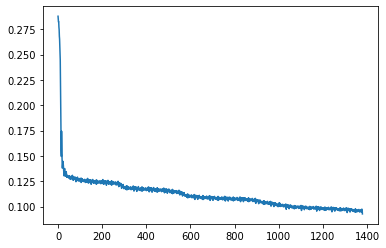

In [ ]:

plt.plot(losses)

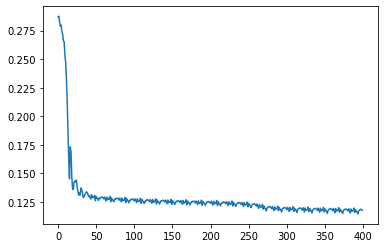

In [73]:
import matplotlib.pyplot as plt

plt.plot(losses)